In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from datetime import date
import holidays

In [2]:
## Christine's Directory
#mydir = "C:/users/cedirp/Downloads/"
#WegmansData = mydir + "WegmansFinalMerged.csv"
#WFD = pd.read_csv(WegmansData)

## Adit's Directory
mydir = "/Users/Adit/Desktop/BANA_785/"
WegmansData = mydir + "WegmansFinalMerged.csv"
WFD = pd.read_csv(WegmansData)


## THINGS TO DO
- Feature engineering
- EDA to help understand new features
- Create target variable
- EDA to understand purchasing behavior
- Engineer features specific to a time series analysis

### EDA & FEATURE ENGINEERING

In [4]:
##reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format
                      (end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# Using  above function to reduce memory usage for Train test df
WFD=reduce_mem_usage(WFD)

Mem. usage decreased to 107.84 Mb (47.6% reduction)


In [6]:
WFD['DATE_KEY'] =  pd.to_datetime(WFD['DATE_KEY'], errors='coerce') #convert to datetime64

In [106]:
WFD.dtypes

TRANSACTION_KEY             float32
DATE_KEY             datetime64[ns]
CUSTOMER_ID                   int16
ITEM_NBR                      int32
UNITS                          int8
WEIGHT                      float16
SALES                       float16
PPU                          object
LOCATION_NBR                   int8
INSTACART_IND                  int8
ITEM_DESCRIPTION             object
PRODUCT_HIERARCHY            object
DEPARTMENT_NAME              object
CATEGORY_NAME                object
CLASS_NAME                   object
DEPT_CAT                     object
DEPT_CLASS                   object
CAT_CLASS                    object
IS_ORGANIC                     int8
IS_FAMILYPACK                  int8
IS_WEGMANSBRAND                int8
HOUSEHOLD_ID                  int16
HOH_AGE                        int8
HH_INCOME                   float32
HH_CHILDREN                    int8
cluster                        int8
DEPTNAME2                    object
WEGMANS_ORGANIC             

In [8]:
#rename columns to make them usable
WFD.rename({'DEPT.CAT': 'DEPT_CAT', 'DEPT.CLASS': 'DEPT_CLASS','CAT.CLASS':'CAT_CLASS'}, axis=1, inplace=True)
WFD

,TRANSACTION_KEY,DATE_KEY,CUSTOMER_ID,ITEM_NBR,UNITS,WEIGHT,SALES,PPU,LOCATION_NBR,INSTACART_IND,...,DEPT_CLASS,CAT_CLASS,IS_ORGANIC,IS_FAMILYPACK,IS_WEGMANSBRAND,HOUSEHOLD_ID,HOH_AGE,HH_INCOME,HH_CHILDREN,cluster
0,6.980000e+18,2020-09-13,10,27746,1,0.0,5.039062,5.04,66,0,...,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1
1,-6.860000e+18,2020-06-28,10,47754,0,0.0,0.000000,-,66,0,...,COMMUNITY RELATIONS ITEMS.WEG2GO DIGITAL TIPS,PERSONAL SHOPPING FEES.WEG2GO DIGITAL TIPS,0,0,0,10,62,125000.0,2,1
2,-6.860000e+18,2020-06-28,10,45978,1,0.0,0.000000,-,66,0,...,OF SUBMARINE SHOP.CHIPS/SNACKS,SNACKS/GROCERY.CHIPS/SNACKS,0,0,1,10,62,125000.0,2,1
3,-6.860000e+18,2020-06-28,10,49316,2,0.0,10.796875,5.4,66,0,...,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1
4,-6.860000e+18,2020-06-28,10,27746,1,0.0,4.679688,4.68,66,0,...,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037401,-5.190000e+18,2019-11-26,7037,128594,1,0.0,6.109375,6.11,25,0,...,PRODUCE.STRAWBERRIES,BERRIES.STRAWBERRIES,0,1,0,3541,36,30000.0,1,6
1037402,-4.760000e+17,2019-10-30,7037,33896,1,0.0,3.949219,3.95,25,0,...,PRODUCE.PEPPERS,SALAD VEGETABLES.PEPPERS,0,1,1,3541,36,30000.0,1,6
1037403,-5.550000e+18,2019-07-22,7037,89326,1,0.0,2.880859,2.88,25,0,...,FLORAL.FILLERS,FRESH BUNCHES.FILLERS,0,0,1,3541,36,30000.0,1,6
1037404,-5.550000e+18,2019-07-22,7037,722724,0,0.0,0.000000,-,25,0,...,COMMUNITY RELATIONS ITEMS.DEPARTMENT STORES,GIFT CARDS - 3RD PARTY.DEPARTMENT STORES,0,0,0,3541,36,30000.0,1,6


In [9]:
WFD['DEPTNAME2'] = WFD['DEPARTMENT_NAME']

Create a new cateogry 'Cleaning Supplies' under Department Name. These items were originally under the cateogry 'Grocery'

In [10]:
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.PAPER TOWELS'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.HOUSEHOLD CLEANERS'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GM BASIC PRODUCTS DEPARTMENT.CLEANING SUPPLIES'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.PAPER NAPKINS'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.BATH TISSUE'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.FACIAL TISSUE'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.LAUNDRY DETERGENT'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.DISH DETERGENT & ADDITIVES'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.AIR CARE'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'HEALTH & BEAUTY CARE.BABY WIPES'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'
WFD.loc[(WFD.DEPT_CAT == 'GROCERY.DIAPERS'),'DEPTNAME2']='GROCERY.CLEANING_SUPPLIES'

In [11]:
WFD['DEPTNAME2'].value_counts()

GROCERY                         328087
PRODUCE                         175370
DAIRY                            91847
FROZEN FOOD                      45276
HEALTH & BEAUTY CARE             41816
MEAT                             37738
CULTURED DAIRY                   34198
BEVERAGE CONTAINER RETURNS       33723
BAKESHOP                         31806
GROCERY.CLEANING_SUPPLIES        23294
COLD CUTS & CHEESE               21756
ICE CREAM                        15656
IN-STORE BREAD & ROLLS           11393
OLDE WORLD CHEESE                11209
COMMUNITY RELATIONS ITEMS        11090
EGGS                             10868
GM BASIC PRODUCTS DEPARTMENT      9957
DAIRY PRE-PACK                    9830
INSTORE BREAKFAST                 9397
BEER & WINE COOLERS               8800
BULK FOODS                        7424
CARD DEPARTMENT                   6452
IN-STORE DESSERTS                 6449
HOMESTYLE AMERICAN                5962
OF SUBMARINE SHOP                 5119
PIZZA                    

In [12]:
#create feature to identify whether a purchased item was wegmans organic brand
def isorganic(WFD):
  if WFD['IS_ORGANIC'] & WFD['IS_WEGMANSBRAND'] == 1:
    return 1
  elif WFD['IS_ORGANIC'] == 0:
    return 0
  elif WFD['IS_WEGMANSBRAND'] == 0:
    return 0
  else:
    return 'Undefined'

In [13]:
#create feature to identify whether a purchased item was wegmans brand family pack
def isfampack(WFD):
  if WFD['IS_FAMILYPACK'] & WFD['IS_WEGMANSBRAND'] == 1:
    return 1
  elif WFD['IS_FAMILYPACK'] == 0:
    return 0
  elif WFD['IS_WEGMANSBRAND'] == 0:
    return 0
  else:
    return 'Undefined'

In [14]:
#create feature to identify whether an item was bought in bulk
def isbulk(WFD):
  if WFD['UNITS'] >= 6:
    return 1
  else:
    return 0

In [15]:
WFD['WEGMANS_ORGANIC'] = WFD.apply(isorganic, axis=1)

In [16]:
WFD['WEGMANS_FAMPACK'] = WFD.apply(isfampack, axis=1)

In [17]:
WFD['IS_BULK'] = WFD.apply(isbulk, axis=1)

Create time variables by splitting (and gathering) the DATE_KEY variable

In [19]:
WFD['quarter'] = WFD['DATE_KEY'].dt.quarter
WFD['weekno'] = WFD['DATE_KEY'].dt.week
WFD['dayofweek'] = WFD['DATE_KEY'].dt.weekday
WFD['year'] = WFD['DATE_KEY'].dt.year

<ipython-input-19-5887b9a61da1>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  WFD['weekno'] = WFD['DATE_KEY'].dt.week


In [71]:
WFD.head(15)

,TRANSACTION_KEY,DATE_KEY,CUSTOMER_ID,ITEM_NBR,UNITS,WEIGHT,SALES,PPU,LOCATION_NBR,INSTACART_IND,ITEM_DESCRIPTION,PRODUCT_HIERARCHY,DEPARTMENT_NAME,CATEGORY_NAME,CLASS_NAME,DEPT_CAT,DEPT_CLASS,CAT_CLASS,IS_ORGANIC,IS_FAMILYPACK,IS_WEGMANSBRAND,HOUSEHOLD_ID,HOH_AGE,HH_INCOME,HH_CHILDREN,cluster,DEPTNAME2,WEGMANS_ORGANIC,WEGMANS_FAMPACK,IS_BULK,quarter,weekno,dayofweek,year,DOM_DEPT,DOM_DEPT_FREQ,DOM_CAT,DOM_CAT_FREQ,DOM_CLASS_x,DOM_CLASS_FREQ_x,DOM_CLASS_y,DOM_CLASS_FREQ_y,DOM_CLASS_x,DOM_CLASS_FREQ_x,DOM_CLASS_y,DOM_CLASS_FREQ_y
0,6.980000e+18,2020-09-13,10,27746,1,0.0,5.039062,5.04,66,0,"Wegmans Old Fashioned 7"" Cold Sub 1 EA",96-70-01,OF SUBMARINE SHOP,SUBMARINE SANDWICHES,MEDIUM SUBS,OF SUBMARINE SHOP.SUBMARINE SANDWICHES,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1,OF SUBMARINE SHOP,0,0,0,3,37,6,2020,GROCERY,599,GROCERY.CHIPS & SNACKS,59,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53
1,-6.860000e+18,2020-06-28,10,47754,0,0.0,0.000000,-,66,0,Weg2Go Digital Tips 1 EA,73-05-05,COMMUNITY RELATIONS ITEMS,PERSONAL SHOPPING FEES,WEG2GO DIGITAL TIPS,COMMUNITY RELATIONS ITEMS.PERSONAL SHOPPING FEES,COMMUNITY RELATIONS ITEMS.WEG2GO DIGITAL TIPS,PERSONAL SHOPPING FEES.WEG2GO DIGITAL TIPS,0,0,0,10,62,125000.0,2,1,COMMUNITY RELATIONS ITEMS,0,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71
2,-6.860000e+18,2020-06-28,10,45978,1,0.0,0.000000,-,66,0,Wegmans Kettle Cooked Reduced Fat Original Po...,96-58-01,OF SUBMARINE SHOP,SNACKS/GROCERY,CHIPS/SNACKS,OF SUBMARINE SHOP.SNACKS/GROCERY,OF SUBMARINE SHOP.CHIPS/SNACKS,SNACKS/GROCERY.CHIPS/SNACKS,0,0,1,10,62,125000.0,2,1,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71
3,-6.860000e+18,2020-06-28,10,49316,2,0.0,10.796875,5.4,66,0,Wegmans Medium Hot Sub (Gluten Free Roll) 1 EA,96-70-01,OF SUBMARINE SHOP,SUBMARINE SANDWICHES,MEDIUM SUBS,OF SUBMARINE SHOP.SUBMARINE SANDWICHES,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71
4,-6.860000e+18,2020-06-28,10,27746,1,0.0,4.679688,4.68,66,0,"Wegmans Old Fashioned 7"" Cold Sub 1 EA",96-70-01,OF SUBMARINE SHOP,SUBMARINE SANDWICHES,MEDIUM SUBS,OF SUBMARINE SHOP.SUBMARINE SANDWICHES,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71
5,8.390000e+18,2020-06-14,10,46287,1,0.0,2.150391,2.15,66,0,Digital Delivery Fees 1 EA,78-01-01,DIGITAL FULFILLMENT,WEGMANS2GO,DELIVERY & SERVICE FEES,DIGITAL FULFILLMENT.WEGMANS2GO,DIGITAL FULFILLMENT.DELIVERY & SERVICE FEES,WEGMANS2GO.DELIVERY & SERVICE FEES,0,0,0,10,62,125000.0,2,1,DIGITAL FULFILLMENT,0,0,0,2,24,6,2020,GROCERY,521,PRODUCE.SALAD VEGETABLES,58,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53,BEVERAGE CONTAINER RETURN

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129b49850>]],
      dtype=object)

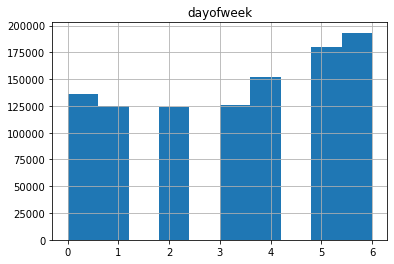

In [20]:
WFD.hist(column = ['dayofweek'])

It seems like sales is lowest on Tuesday and Wednesday (Day 1 and Day 2) and sees a large increase as the weekend arrives, with highest volume of sales typically seen on Sundays. 

In [73]:
WFD['LOCATION_NBR'].value_counts()

25    79242
24    78775
63    72645
68    69630
66    64379
20    60885
18    59439
22    58580
64    57319
3     56885
11    56621
67    48630
12    47349
13    46949
65    40761
19    36868
62    32457
74    26494
6     21944
4     21554
Name: LOCATION_NBR, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f9762e0>]],
      dtype=object)

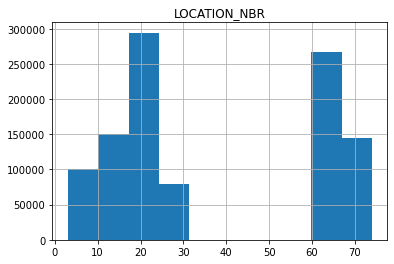

In [21]:
WFD.hist(column = ['LOCATION_NBR'])

There doesn't seem to be a set pattern in sales across different stores. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12fb14d30>]],
      dtype=object)

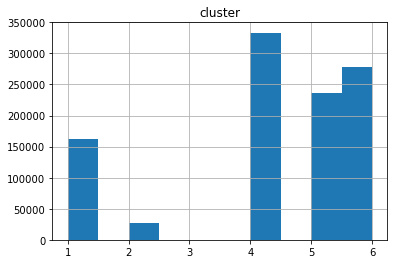

In [22]:
WFD.hist(column = ['cluster'])

Cluster 4, with an average age of 54.35 and average household income of 66,637.24 dollars seems to have the highest volume of sales associated with it, whereas the smallest cluster had an average age of 57.39 and average household income of 68,162.39 dollars. It is important to note that the size of the transactions were significantly larger for cluster 3, with average sales being 630.79 dollars, compared to 2.91 dollars for cluster 4.

### TRYING TO DETERMINE A TARGET VARIABLE

In [23]:
dept_freq = WFD.groupby(['DATE_KEY', 'DEPTNAME2']).size()

In [24]:
dept_count_cols = WFD[["DATE_KEY", "DEPTNAME2"]]

In [25]:
#identify most popular department for each date_key
deptfreq=dept_count_cols.groupby(['DATE_KEY','DEPTNAME2']).size().sort_values().groupby(level=0).tail(1).reset_index()
deptfreq.sort_values(by='DATE_KEY')

,DATE_KEY,DEPTNAME2,0
683,2019-01-06,GROCERY,670
320,2019-01-07,GROCERY,410
80,2019-01-08,GROCERY,333
346,2019-01-09,GROCERY,420
3,2019-01-10,GROCERY,249
...,...,...,...
401,2020-12-27,GROCERY,439
126,2020-12-28,GROCERY,351
183,2020-12-29,GROCERY,367
564,2020-12-30,GROCERY,533


In [26]:
deptfreq = deptfreq.rename({'DEPTNAME2': 'DOM_DEPT', 0 : 'DOM_DEPT_FREQ'}, axis = 1)
deptfreq

,DATE_KEY,DOM_DEPT,DOM_DEPT_FREQ
0,2019-01-20,GROCERY,155
1,2020-11-26,GROCERY,170
2,2019-11-28,GROCERY,196
3,2019-01-10,GROCERY,249
4,2019-03-27,GROCERY,280
...,...,...,...
719,2019-12-23,GROCERY,855
720,2020-03-13,GROCERY,916
721,2020-03-14,GROCERY,995
722,2020-03-12,GROCERY,1059


It seems that 'Grocery' is the most popular department across all dates. A more granular view may help us

In [27]:
WFD = WFD.merge(deptfreq, how = 'left', on = 'DATE_KEY')
WFD

,TRANSACTION_KEY,DATE_KEY,CUSTOMER_ID,ITEM_NBR,UNITS,WEIGHT,SALES,PPU,LOCATION_NBR,INSTACART_IND,...,DEPTNAME2,WEGMANS_ORGANIC,WEGMANS_FAMPACK,IS_BULK,quarter,weekno,dayofweek,year,DOM_DEPT,DOM_DEPT_FREQ
0,6.980000e+18,2020-09-13,10,27746,1,0.0,5.039062,5.04,66,0,...,OF SUBMARINE SHOP,0,0,0,3,37,6,2020,GROCERY,599
1,-6.860000e+18,2020-06-28,10,47754,0,0.0,0.000000,-,66,0,...,COMMUNITY RELATIONS ITEMS,0,0,0,2,26,6,2020,GROCERY,523
2,-6.860000e+18,2020-06-28,10,45978,1,0.0,0.000000,-,66,0,...,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523
3,-6.860000e+18,2020-06-28,10,49316,2,0.0,10.796875,5.4,66,0,...,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523
4,-6.860000e+18,2020-06-28,10,27746,1,0.0,4.679688,4.68,66,0,...,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037401,-5.190000e+18,2019-11-26,7037,128594,1,0.0,6.109375,6.11,25,0,...,PRODUCE,0,0,0,4,48,1,2019,GROCERY,655
1037402,-4.760000e+17,2019-10-30,7037,33896,1,0.0,3.949219,3.95,25,0,...,PRODUCE,0,1,0,4,44,2,2019,GROCERY,399
1037403,-5.550000e+18,2019-07-22,7037,89326,1,0.0,2.880859,2.88,25,0,...,FLORAL,0,0,0,3,30,0,2019,GROCERY,441
1037404,-5.550000e+18,2019-07-22,7037,722724,0,0.0,0.000000,-,25,0,...,COMMUNITY RELATIONS ITEMS,0,0,0,3,30,0,2019,GROCERY,441


In [29]:
#groupby department.category
cat_freq = WFD.groupby(['DATE_KEY', 'DEPT_CAT']).size()

In [30]:
cat_count_cols = WFD[["DATE_KEY", "DEPT_CAT"]]

In [31]:
catfreq=cat_count_cols.groupby(['DATE_KEY','DEPT_CAT']).size().sort_values().groupby(level=0).tail(1).reset_index()
catfreq.sort_values(by='DATE_KEY')

,DATE_KEY,DEPT_CAT,0
701,2019-01-06,CULTURED DAIRY.YOGURT,79
276,2019-01-07,CULTURED DAIRY.YOGURT,42
23,2019-01-08,PRODUCE.COOKING VEGETABLES,30
128,2019-01-09,CULTURED DAIRY.YOGURT,36
2,2019-01-10,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,26
...,...,...,...
298,2020-12-27,PRODUCE.SALAD VEGETABLES,43
18,2020-12-28,PRODUCE.COOKING VEGETABLES,29
478,2020-12-29,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,52
561,2020-12-30,GROCERY.CHIPS & SNACKS,59


In [32]:
catfreq = catfreq.rename({'DEPT_CAT': 'DOM_CAT', 0 : 'DOM_CAT_FREQ'}, axis = 1)
catfreq

,DATE_KEY,DOM_CAT,DOM_CAT_FREQ
0,2019-01-20,GROCERY.CHIPS & SNACKS,21
1,2020-11-26,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,24
2,2019-01-10,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,26
3,2019-10-08,GROCERY.CHIPS & SNACKS,26
4,2020-01-01,PRODUCE.COOKING VEGETABLES,27
...,...,...,...
719,2019-07-03,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,88
720,2019-02-03,GROCERY.CHIPS & SNACKS,90
721,2020-03-14,GROCERY.CHIPS & SNACKS,92
722,2020-03-12,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,92


In [33]:
catfreq['DOM_CAT'].value_counts()

BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER DEPOSITS    368
GROCERY.CHIPS & SNACKS                                    209
CULTURED DAIRY.YOGURT                                      77
PRODUCE.COOKING VEGETABLES                                 22
PRODUCE.SALAD VEGETABLES                                   22
DAIRY.MILK                                                 12
PRODUCE.SALADS AND SALAD KITS                               8
GROCERY.CARBONATED SODA POP                                 3
PRODUCE.BERRIES                                             2
GROCERY.HOLIDAY CANDY                                       1
Name: DOM_CAT, dtype: int64

'BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER DEPOSITS' seems to be quite popular, whereas 'Grocery' does not seem as popular while using the DEPT_CAT variable. We'll take a deeper look at this by plotting these variables.

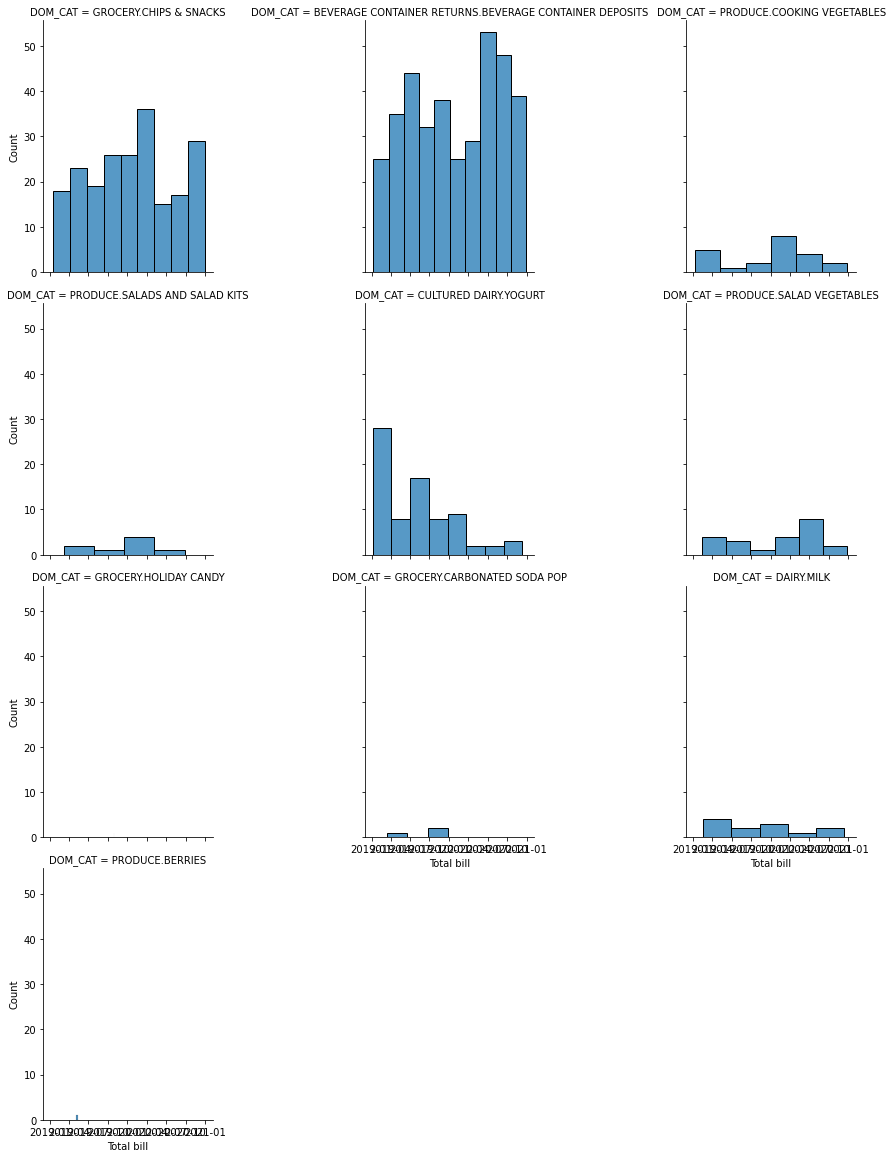

In [62]:
g = sns.FacetGrid(catfreq, col="DOM_CAT", height=4, col_wrap=3)#,  row="sex")
g.map_dataframe(sns.histplot, x="DATE_KEY")
g.set_axis_labels("Total bill", "Count")
g.fig.subplots_adjust(wspace=.9)



In [34]:
WFD = WFD.merge(catfreq, how = 'left', on = 'DATE_KEY')
WFD

,TRANSACTION_KEY,DATE_KEY,CUSTOMER_ID,ITEM_NBR,UNITS,WEIGHT,SALES,PPU,LOCATION_NBR,INSTACART_IND,...,WEGMANS_FAMPACK,IS_BULK,quarter,weekno,dayofweek,year,DOM_DEPT,DOM_DEPT_FREQ,DOM_CAT,DOM_CAT_FREQ
0,6.980000e+18,2020-09-13,10,27746,1,0.0,5.039062,5.04,66,0,...,0,0,3,37,6,2020,GROCERY,599,GROCERY.CHIPS & SNACKS,59
1,-6.860000e+18,2020-06-28,10,47754,0,0.0,0.000000,-,66,0,...,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71
2,-6.860000e+18,2020-06-28,10,45978,1,0.0,0.000000,-,66,0,...,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71
3,-6.860000e+18,2020-06-28,10,49316,2,0.0,10.796875,5.4,66,0,...,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71
4,-6.860000e+18,2020-06-28,10,27746,1,0.0,4.679688,4.68,66,0,...,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037401,-5.190000e+18,2019-11-26,7037,128594,1,0.0,6.109375,6.11,25,0,...,0,0,4,48,1,2019,GROCERY,655,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,62
1037402,-4.760000e+17,2019-10-30,7037,33896,1,0.0,3.949219,3.95,25,0,...,1,0,4,44,2,2019,GROCERY,399,GROCERY.CHIPS & SNACKS,47
1037403,-5.550000e+18,2019-07-22,7037,89326,1,0.0,2.880859,2.88,25,0,...,0,0,3,30,0,2019,GROCERY,441,PRODUCE.SALADS AND SALAD KITS,40
1037404,-5.550000e+18,2019-07-22,7037,722724,0,0.0,0.000000,-,25,0,...,0,0,3,30,0,2019,GROCERY,441,PRODUCE.SALADS AND SALAD KITS,40


In [35]:
class_freq = WFD.groupby(['DATE_KEY', 'DEPT_CLASS']).size()

In [36]:
class_count_cols = WFD[["DATE_KEY", "DEPT_CLASS"]]

In [37]:
classfreq=class_count_cols.groupby(['DATE_KEY','DEPT_CLASS']).size().sort_values().groupby(level=0).tail(1).reset_index()
classfreq.sort_values(by='DATE_KEY')

,DATE_KEY,DEPT_CLASS,0
471,2019-01-06,CULTURED DAIRY.GREEK - STRAINED,48
241,2019-01-07,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,37
28,2019-01-08,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,25
220,2019-01-09,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,36
32,2019-01-10,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,26
...,...,...,...
184,2020-12-27,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,34
83,2020-12-28,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,29
525,2020-12-29,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,52
610,2020-12-30,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,58


In [38]:
classfreq = classfreq.rename({'DEPT_CLASS': 'DOM_CLASS', 0 : 'DOM_CLASS_FREQ'}, axis = 1)
classfreq

,DATE_KEY,DOM_CLASS,DOM_CLASS_FREQ
0,2019-01-20,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,14
1,2019-10-21,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,21
2,2019-02-19,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,21
3,2020-03-24,PRODUCE.BANANAS,21
4,2020-10-20,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,22
...,...,...,...
719,2020-07-03,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,86
720,2019-12-31,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,87
721,2019-01-18,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,87
722,2019-07-03,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,88


In [49]:
classfreq['DOM_CLASS'].value_counts()

BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (LINKS)    711
PRODUCE.BANANAS                                           7
CULTURED DAIRY.GREEK - STRAINED                           3
DAIRY.LOWFAT & SKIM                                       1
GROCERY.HALLOWEEN CANDY                                   1
COMMUNITY RELATIONS ITEMS.PAPER BAG CHARGE                1
Name: DOM_CLASS, dtype: int64

In [66]:
WFD = WFD.merge(classfreq, how = 'left', on = 'DATE_KEY')
WFD.head(5)

,TRANSACTION_KEY,DATE_KEY,CUSTOMER_ID,ITEM_NBR,UNITS,WEIGHT,SALES,PPU,LOCATION_NBR,INSTACART_IND,ITEM_DESCRIPTION,PRODUCT_HIERARCHY,DEPARTMENT_NAME,CATEGORY_NAME,CLASS_NAME,DEPT_CAT,DEPT_CLASS,CAT_CLASS,IS_ORGANIC,IS_FAMILYPACK,IS_WEGMANSBRAND,HOUSEHOLD_ID,HOH_AGE,HH_INCOME,HH_CHILDREN,cluster,DEPTNAME2,WEGMANS_ORGANIC,WEGMANS_FAMPACK,IS_BULK,quarter,weekno,dayofweek,year,DOM_DEPT,DOM_DEPT_FREQ,DOM_CAT,DOM_CAT_FREQ,DOM_CLASS_x,DOM_CLASS_FREQ_x,DOM_CLASS_y,DOM_CLASS_FREQ_y,DOM_CLASS_x,DOM_CLASS_FREQ_x,DOM_CLASS_y,DOM_CLASS_FREQ_y
0,6.980000e+18,2020-09-13,10,27746,1,0.0,5.039062,5.04,66,0,"Wegmans Old Fashioned 7"" Cold Sub 1 EA",96-70-01,OF SUBMARINE SHOP,SUBMARINE SANDWICHES,MEDIUM SUBS,OF SUBMARINE SHOP.SUBMARINE SANDWICHES,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1,OF SUBMARINE SHOP,0,0,0,3,37,6,2020,GROCERY,599,GROCERY.CHIPS & SNACKS,59,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,53
1,-6.860000e+18,2020-06-28,10,47754,0,0.0,0.000000,-,66,0,Weg2Go Digital Tips 1 EA,73-05-05,COMMUNITY RELATIONS ITEMS,PERSONAL SHOPPING FEES,WEG2GO DIGITAL TIPS,COMMUNITY RELATIONS ITEMS.PERSONAL SHOPPING FEES,COMMUNITY RELATIONS ITEMS.WEG2GO DIGITAL TIPS,PERSONAL SHOPPING FEES.WEG2GO DIGITAL TIPS,0,0,0,10,62,125000.0,2,1,COMMUNITY RELATIONS ITEMS,0,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71
2,-6.860000e+18,2020-06-28,10,45978,1,0.0,0.000000,-,66,0,Wegmans Kettle Cooked Reduced Fat Original Po...,96-58-01,OF SUBMARINE SHOP,SNACKS/GROCERY,CHIPS/SNACKS,OF SUBMARINE SHOP.SNACKS/GROCERY,OF SUBMARINE SHOP.CHIPS/SNACKS,SNACKS/GROCERY.CHIPS/SNACKS,0,0,1,10,62,125000.0,2,1,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71
3,-6.860000e+18,2020-06-28,10,49316,2,0.0,10.796875,5.4,66,0,Wegmans Medium Hot Sub (Gluten Free Roll) 1 EA,96-70-01,OF SUBMARINE SHOP,SUBMARINE SANDWICHES,MEDIUM SUBS,OF SUBMARINE SHOP.SUBMARINE SANDWICHES,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71
4,-6.860000e+18,2020-06-28,10,27746,1,0.0,4.679688,4.68,66,0,"Wegmans Old Fashioned 7"" Cold Sub 1 EA",96-70-01,OF SUBMARINE SHOP,SUBMARINE SANDWICHES,MEDIUM SUBS,OF SUBMARINE SHOP.SUBMARINE SANDWICHES,OF SUBMARINE SHOP.MEDIUM SUBS,SUBMARINE SANDWICHES.MEDIUM SUBS,0,0,1,10,62,125000.0,2,1,OF SUBMARINE SHOP,0,0,0,2,26,6,2020,GROCERY,523,BEVERAGE CONTAINER RETURNS.BEVERAGE CONTAINER ...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,71


In [78]:
pd.set_option('display.max_columns', 20)
age_trend=WFD.groupby(['HOH_AGE','DOM_CAT']).size().sort_values().groupby(level=0).tail(1).reset_index()
#age_trend.head(5)

In order to find whether age or income had were related to Beverage Container Deposits, we gruped DATE_KEY, DEPT_CLASS, HH_INCOME, and HOH_AGE

In [59]:
cat_inc_dist = WFD.groupby(['DATE_KEY', 'DEPT_CLASS','HH_INCOME',"HOH_AGE"]).size()
cat_inc_cols = WFD[["DATE_KEY", "DEPT_CLASS","HH_INCOME","HOH_AGE"]]
cat_inc_dist=cat_inc_cols.groupby(["DATE_KEY", "DEPT_CLASS","HH_INCOME","HOH_AGE"]).size().sort_values().groupby(level=0).tail(1).reset_index()
cat_inc_dist.sort_values(by='DATE_KEY')

,DATE_KEY,DEPT_CLASS,HH_INCOME,HOH_AGE,0
700,2019-01-06,GROCERY.STAGE 2,75000.000000,37,6
449,2019-01-07,CULTURED DAIRY.BLENDED YOGURT,100000.000000,33,4
718,2019-01-08,GROCERY.PREMIUM CANNED CAT FOOD,50000.000000,70,8
672,2019-01-09,GROCERY.PREMIUM CANNED DOG FOOD,50000.000000,81,6
271,2019-01-10,PRODUCE.SALAD BOWLS,50000.000000,30,3
231,2019-01-11,GROCERY.CSD 2 LITER,10000.000000,30,3
650,2019-01-12,GROCERY.SPARKLING WATER 1L,40000.000000,44,5
557,2019-01-13,FROZEN FOOD.CORE POLY VEG,40000.000000,50,4
349,2019-01-14,GROCERY.PREMIUM CANNED CAT FOOD,100000.000000,76,4
334,2019-01-15,GROCERY.RDY TO EAT SOUPS,125000.000000,65,4


In [83]:
bev_deposits = cat_inc_dist.loc[cat_inc_dist['DEPT_CLASS']=='BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (LINKS)']
bev_deposits = bev_deposits.rename({ 0 : 'BEV_CLASS_FREQ'}, axis = 1)

bev_deposits.head(5)

,DATE_KEY,DEPT_CLASS,HH_INCOME,HOH_AGE,BEV_CLASS_FREQ
19,2020-11-13,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,50000.0,67,3
21,2020-08-11,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,40000.0,67,3
54,2019-09-27,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,75000.0,58,3
65,2019-05-21,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,10000.0,35,3
79,2019-05-04,BEVERAGE CONTAINER RETURNS.BEVERAGE DEPOSITS (...,50000.0,44,3


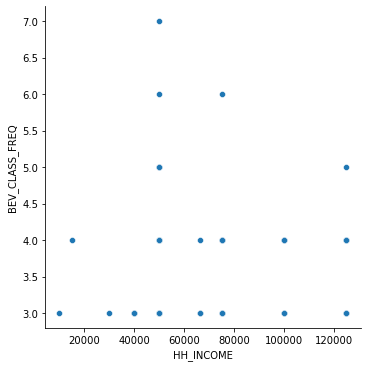

In [84]:
sns.relplot(x="HH_INCOME", y="BEV_CLASS_FREQ", data=bev_deposits);


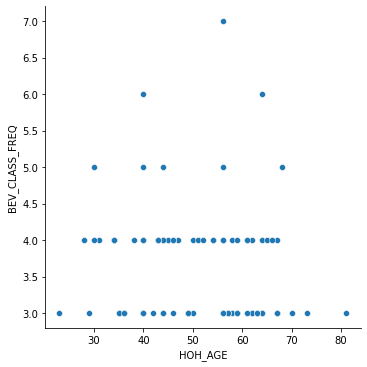

In [85]:
sns.relplot(x="HOH_AGE", y="BEV_CLASS_FREQ", data=bev_deposits);


In [86]:
bev_deposits["HH_INCOME"].mean()

66977.77645596591

In [131]:
objList = WFD.select_dtypes(include = "object").columns
print (objList)

Index(['PPU', 'ITEM_DESCRIPTION', 'PRODUCT_HIERARCHY', 'DEPARTMENT_NAME',
       'CATEGORY_NAME', 'CLASS_NAME', 'DEPT_CAT', 'DEPT_CLASS', 'CAT_CLASS',
       'DEPTNAME2', 'DOM_DEPT', 'DOM_CAT'],
      dtype='object')


In [132]:
#type(objList)
objList= objList.drop('PPU')
print (objList)

Index(['ITEM_DESCRIPTION', 'PRODUCT_HIERARCHY', 'DEPARTMENT_NAME',
       'CATEGORY_NAME', 'CLASS_NAME', 'DEPT_CAT', 'DEPT_CLASS', 'CAT_CLASS',
       'DEPTNAME2', 'DOM_DEPT', 'DOM_CAT'],
      dtype='object')


In [122]:
del WFD['DOM_CLASS_x']
del WFD['DOM_CLASS_y']
del WFD['DOM_CLASS_FREQ_x']
del WFD['DOM_CLASS_FREQ_y']


In [136]:
#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for foo in objList:
    WFD[foo] = le.fit_transform(WFD[foo].astype(str))

print (WFD.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037406 entries, 0 to 1037405
Data columns (total 38 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   TRANSACTION_KEY    1037406 non-null  float32       
 1   DATE_KEY           1037406 non-null  datetime64[ns]
 2   CUSTOMER_ID        1037406 non-null  int16         
 3   ITEM_NBR           1037406 non-null  int32         
 4   UNITS              1037406 non-null  int8          
 5   WEIGHT             1037406 non-null  float16       
 6   SALES              1037406 non-null  float16       
 7   PPU                1037406 non-null  object        
 8   LOCATION_NBR       1037406 non-null  int8          
 9   INSTACART_IND      1037406 non-null  int8          
 10  ITEM_DESCRIPTION   1037406 non-null  int64         
 11  PRODUCT_HIERARCHY  1037406 non-null  int64         
 12  DEPARTMENT_NAME    1037406 non-null  int64         
 13  CATEGORY_NAME      1037406 

In [138]:
WFD_encoded=reduce_mem_usage(WFD)

Mem. usage decreased to 83.11 Mb (0.0% reduction)


### MORE EDA & FEATURE ENGINEERING

In [41]:
CustGroup = WFD.groupby('CUSTOMER_ID')['TRANSACTION_KEY'].nunique()

In [42]:
CustGroup = pd.DataFrame(CustGroup)

In [43]:
CustGroup.sort_values(by='TRANSACTION_KEY', ascending = False)[:50]

,TRANSACTION_KEY
CUSTOMER_ID,
3682,387
2419,386
3962,380
1283,373
3595,369
1224,366
55,360
1787,357
1546,354


In [44]:
dates = WFD[['DATE_KEY']]
dates.head()

,DATE_KEY
0,2020-09-13
1,2020-06-28
2,2020-06-28
3,2020-06-28
4,2020-06-28


In [45]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [46]:
cal = calendar()

In [47]:
dates['DATE_KEY'].min()

Timestamp('2019-01-06 00:00:00')

In [48]:
dates['DATE_KEY'].max()

Timestamp('2020-12-31 00:00:00')

In [49]:
#extract dates that are holidays in the US
holidays = cal.holidays(start=dates['DATE_KEY'].min(), end=dates['DATE_KEY'].max())
holidays

DatetimeIndex(['2019-01-21', '2019-02-18', '2019-05-27', '2019-07-04',
               '2019-09-02', '2019-10-14', '2019-11-11', '2019-11-28',
               '2019-12-25', '2020-01-01', '2020-01-20', '2020-02-17',
               '2020-05-25', '2020-07-03', '2020-09-07', '2020-10-12',
               '2020-11-11', '2020-11-26', '2020-12-25'],
              dtype='datetime64[ns]', freq=None)

In [50]:
holidays = pd.DataFrame(holidays)

In [51]:
holidays.columns = ['DATE_KEY']

In [52]:
holidays['holiday'] = 'TRUE'

In [53]:
holidays

,DATE_KEY,holiday
0,2019-01-21,TRUE
1,2019-02-18,TRUE
2,2019-05-27,TRUE
3,2019-07-04,TRUE
4,2019-09-02,TRUE
5,2019-10-14,TRUE
6,2019-11-11,TRUE
7,2019-11-28,TRUE
8,2019-12-25,TRUE
9,2020-01-01,TRUE


In [54]:
dates = dates.merge(holidays, how = 'left', on = 'DATE_KEY')

In [55]:
dates['holiday'].fillna('FALSE', inplace = True)

In [56]:
dates[(dates['holiday'] == 'TRUE')]

,DATE_KEY,holiday
46,2020-10-12,TRUE
173,2019-11-28,TRUE
174,2019-11-28,TRUE
249,2019-09-02,TRUE
282,2019-07-04,TRUE
...,...,...
1037312,2019-01-21,TRUE
1037313,2019-01-21,TRUE
1037314,2019-01-21,TRUE
1037315,2019-01-21,TRUE


In [291]:
dates.head()

,DATE_KEY,holiday
0,2020-09-13,FALSE
1,2020-06-28,FALSE
2,2020-06-28,FALSE
3,2020-06-28,FALSE
4,2020-06-28,FALSE


In [293]:
WFD = WFD.merge(dates, how = 'left', on = 'DATE_KEY')

MemoryError: 

Identify key COVID-19 related dates. These dates pertain to key events that led to significant change in social behavior.

In [57]:
keyCOVIDdates = ['2020-01-17','2020-02-29','2020-03-01','2020-03-07','2020-03-14','2020-03-16',
                 '2020-03-20','2020-04-15','2020-05-15','2020-05-27','2020-06-02','2020-06-11',
                 '2020-06-26','2020-07-07','2020-07-16','2020-08-17','2020-10-05']

In [58]:
len(keyCOVIDdates)

17

In [59]:
keyCOVIDdescriptions = ['First coronavirus in the USA','Coronavirus test approved by FDA','First coronavirus case in NYS',
                       'NYS State of Emergency declared','First coronavirus-related death in NYS','Schools closed statewide',
                       'NYS on PAUSE','NYS residents to wear face masks in public','Phase 1 reopening - Monroe County',
                       'U.S. COVID-19 deaths pass 100,000','Phase 2 reopening - Monroe County','Phase 3 reopening - Monroe County',
                       'Phase 4 reopening - Monroe County', 'NYS schools can open to in-person instruction','Alcohol can only be served  to people ordering food.',
                       'Gyms and low-risk cultural activities can resume','NYS schools with high COVID rates must close']

In [60]:
len(keyCOVIDdescriptions)

17

In [61]:
COVIDlist = pd.DataFrame({'keyCOVIDdates': keyCOVIDdates,'keyCOVIDdescriptions': keyCOVIDdescriptions})

In [62]:
COVIDlist

,keyCOVIDdates,keyCOVIDdescriptions
0,2020-01-17,First coronavirus in the USA
1,2020-02-29,Coronavirus test approved by FDA
2,2020-03-01,First coronavirus case in NYS
3,2020-03-07,NYS State of Emergency declared
4,2020-03-14,First coronavirus-related death in NYS
5,2020-03-16,Schools closed statewide
6,2020-03-20,NYS on PAUSE
7,2020-04-15,NYS residents to wear face masks in public
8,2020-05-15,Phase 1 reopening - Monroe County
9,2020-05-27,"U.S. COVID-19 deaths pass 100,000"


In [63]:
COVIDlist.dtypes

keyCOVIDdates           object
keyCOVIDdescriptions    object
dtype: object

In [64]:
COVIDlist['keyCOVIDdates'] = pd.to_datetime(COVIDlist['keyCOVIDdates'], format='%Y-%m-%d')

In [65]:
COVIDlist.dtypes

keyCOVIDdates           datetime64[ns]
keyCOVIDdescriptions            object
dtype: object

In [ ]:
WFD = WFD.merge(COVIDlist, how = 'left')
WFD

#### TIME SERIES ANALYSIS

In [141]:
##SPLIT DATA INTO TRAIN/TEST BY YEAR

train = WFD.loc[WFD['year'] == '2019'] 
test = WFD.loc[WFD['year'] == '2020'] 

In [143]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    WFD['sold_lag_'+str(lag)] = WFD.groupby(['ID', 'ITEM_ID', 'DEPT_ID', 'CAT_ID', 'STORE_ID', 'STATE_ID'],as_index=False)['sold'].shift(lag).astype(np.float16)
    

KeyError: 'ID'

In [144]:
##Mean Encoding
WFD['item_sold_avg'] = WFD.groupby('item_id')['sold'].transform('mean').astype(np.float16)
WFD['state_sold_avg'] = WFD.groupby('state_id')['sold'].transform('mean').astype(np.float16)
WFD['store_sold_avg'] = WFD.groupby('store_id')['sold'].transform('mean').astype(np.float16)
WFD['cat_sold_avg'] = WFD.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
WFD['dept_sold_avg'] = WFD.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
WFD['cat_dept_sold_avg'] = WFD.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
WFD['store_item_sold_avg'] = WFD.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
WFD['cat_item_sold_avg'] = WFD.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
WFD['dept_item_sold_avg'] = WFD.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
WFD['state_store_sold_avg'] = WFD.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
WFD['state_store_cat_sold_avg'] = WFD.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
WFD['store_cat_dept_sold_avg'] = WFD.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

KeyError: 'item_id'

#### NEURAL NETWORK